1. Что бы не было проблем с загрузкой файл из-за ограничений колаба (+не загружать на гугл диск), настраиваю автоматическое скачивание датасета. Желательно по очереди перезапустить каждый блок.

In [1]:
! pip install kaggle
! sudo rm ~/.kaggle/kaggle.json
! sudo rmdir ~/.kaggle
! sudo mkdir ~/.kaggle

rm: cannot remove '/root/.kaggle/kaggle.json': No such file or directory
rmdir: failed to remove '/root/.kaggle': No such file or directory


In [2]:
# То что ключ лежит таким образом, понимаю что не безопасно.

! sudo echo '{"username":"rup1990","key":"c2c5c0c77d20a755667fd4153bda647b"}' > ~/.kaggle/kaggle.json

In [3]:
! sudo chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download yasserh/titanic-dataset
! unzip -d /usr/ -o titanic-dataset.zip

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 34.2MB/s]
Archive:  titanic-dataset.zip
  inflating: /usr/Titanic-Dataset.csv  


2. Тут начинается обработка файла

In [5]:
import numpy as np
import pandas as pd
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Загружаем файл в датафрейм

filename = "/usr/Titanic-Dataset.csv"
titanik_ds = pd.DataFrame(pd.read_csv (filename))
titanik_ds.set_index('PassengerId', inplace=True)

# Выведем набор данных

titanik_ds


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [ ]:
# Считаем количество пустых ячеек

empty_cells_count = titanik_ds.isnull().sum()
empty_cells_count

In [8]:
# Вариант1. Заполним пустые значения

titanik_ds_filled = titanik_ds.copy()
titanik_ds_filled['Age'].fillna(method='ffill', inplace=True)
titanik_ds_filled['Cabin'].fillna('In the pantry', inplace=True)
titanik_ds_filled['Embarked'].fillna(method='ffill', inplace=True)
#titanik_ds_filled

In [11]:
# Вариант2. Удаляем пустые строки, в которых отсутствует хотя бы одно значение по колонкам age и Embarked
"""Объясняется тем, что правильнее удалять строки а не заполнять их синтетичекими данными, так как это влияет на качество данных.
У нас есть три колонки с пропусками, но очищаю только по двум, так как номер кают без данных о её размещении не явлюются ценными данными.
Предполагаю что стоит исключить из анализа эту колонку """

titanik_ds_dropped = titanik_ds.copy()
titanik_ds_dropped = titanik_ds_dropped.dropna(subset=['Age','Embarked'])
#titanik_ds_dropped

In [12]:
del titanik_ds_dropped['Cabin']
#titanik_ds_dropped

In [ ]:
# Проверяем что не осталось пустых ячеек (Вариант 1)

empty_cells_count_v1 = titanik_ds_filled.isnull().sum()
empty_cells_count_v1

In [ ]:
# Проверяем что не осталось пустых ячеек (Варианту 2)

empty_cells_count_v2 = titanik_ds_dropped.isnull().sum()
empty_cells_count_v2

In [ ]:
# Проверяем количество уникальных значений по каждаму параметру (Вариант 1)

unics_values = titanik_ds_filled.nunique()
unics_values

In [ ]:
# Проверяем количество уникальных значений по каждаму параметру по (Вариант 2)

unics_values = titanik_ds_dropped.nunique()
unics_values

In [ ]:
# Проверяем минимальное значения для каждого параметра (Вариант 1)

min_val = titanik_ds_filled.min()
min_val

In [ ]:
# Проверяем минимальное значения для каждого параметра (Вариант 2)

min_val = titanik_ds_dropped.min(numeric_only=None)
min_val

In [ ]:
# Проверяем максимальное значения для каждого параметра (Вариан 1)

max_val = titanik_ds_filled.max()
max_val

In [ ]:
# Проверяем максимальное значения для каждого параметра (Вариант 2)

max_val = titanik_ds_dropped.max()
max_val

3. С помощью аналитики определить влияние всех признаков на признак Survived (выживание)

In [13]:
# Рассчитаем коэффициенты корреляции между параметром выжываемости и остальными числовыми параметрами (Вариант 1)

correlation_coef = titanik_ds_filled.corr(numeric_only = True)['Survived']
correlation_coef

Survived    1.000000
Pclass     -0.338481
Age        -0.065571
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

In [14]:
# Рассчитаем коэффициенты корреляции между параметром выжываемости и остальными числовыми параметрами (Вариант 2)

correlation_coef = titanik_ds_dropped.corr(numeric_only = True)['Survived']
correlation_coef

Survived    1.000000
Pclass     -0.356462
Age        -0.082446
SibSp      -0.015523
Parch       0.095265
Fare        0.266100
Name: Survived, dtype: float64

In [15]:
# Группируем значения, что бы понять среднее влияние каждого значения (Вариант 1)
"""Исключил некоторые параметры, которые, как мне показалось, не влияют на конечный результат"""

grouped_data_sex = titanik_ds_filled.groupby('Sex')['Survived'].mean()
grouped_data_pclass = titanik_ds_filled.groupby('Pclass')['Survived'].mean()
grouped_data_age = titanik_ds_filled.groupby('Age')['Survived'].mean()
grouped_data_sibsp = titanik_ds_filled.groupby('SibSp')['Survived'].mean()
grouped_data_parch = titanik_ds_filled.groupby('Parch')['Survived'].mean()
grouped_data_fare = titanik_ds_filled.groupby('Fare')['Survived'].mean()
grouped_data_embarked  = titanik_ds_filled.groupby('Embarked')['Survived'].mean()
grouped_data_sex, grouped_data_pclass, grouped_data_age, grouped_data_sibsp, grouped_data_parch, grouped_data_fare, grouped_data_embarked

(Sex
 female    0.742038
 male      0.188908
 Name: Survived, dtype: float64,
 Pclass
 1    0.629630
 2    0.472826
 3    0.242363
 Name: Survived, dtype: float64,
 Age
 0.42     1.000000
 0.67     1.000000
 0.75     0.666667
 0.83     0.666667
 0.92     1.000000
            ...   
 70.00    0.000000
 70.50    0.000000
 71.00    0.000000
 74.00    0.000000
 80.00    1.000000
 Name: Survived, Length: 88, dtype: float64,
 SibSp
 0    0.345395
 1    0.535885
 2    0.464286
 3    0.250000
 4    0.166667
 5    0.000000
 8    0.000000
 Name: Survived, dtype: float64,
 Parch
 0    0.343658
 1    0.550847
 2    0.500000
 3    0.600000
 4    0.000000
 5    0.200000
 6    0.000000
 Name: Survived, dtype: float64,
 Fare
 0.0000      0.066667
 4.0125      0.000000
 5.0000      0.000000
 6.2375      0.000000
 6.4375      0.000000
               ...   
 227.5250    0.750000
 247.5208    0.500000
 262.3750    1.000000
 263.0000    0.500000
 512.3292    1.000000
 Name: Survived, Length: 248, dtype: fl

In [16]:
# Группируем значения, что бы понять среднее влияние каждого значения (Вариант 2)
"""Исключил некоторые параметры, которые, как мне показалось, не влияют на конечный результат"""

grouped_data_sex = titanik_ds_dropped.groupby('Sex')['Survived'].mean()
grouped_data_pclass = titanik_ds_dropped.groupby('Pclass')['Survived'].mean()
grouped_data_age = titanik_ds_dropped.groupby('Age')['Survived'].mean()
grouped_data_sibsp = titanik_ds_dropped.groupby('SibSp')['Survived'].mean()
grouped_data_parch = titanik_ds_dropped.groupby('Parch')['Survived'].mean()
grouped_data_fare = titanik_ds_dropped.groupby('Fare')['Survived'].mean()
grouped_data_embarked  = titanik_ds_dropped.groupby('Embarked')['Survived'].mean()
grouped_data_sex, grouped_data_pclass, grouped_data_age, grouped_data_sibsp, grouped_data_parch, grouped_data_fare, grouped_data_embarked

(Sex
 female    0.752896
 male      0.205298
 Name: Survived, dtype: float64,
 Pclass
 1    0.652174
 2    0.479769
 3    0.239437
 Name: Survived, dtype: float64,
 Age
 0.42     1.0
 0.67     1.0
 0.75     1.0
 0.83     1.0
 0.92     1.0
         ... 
 70.00    0.0
 70.50    0.0
 71.00    0.0
 74.00    0.0
 80.00    1.0
 Name: Survived, Length: 88, dtype: float64,
 SibSp
 0    0.368870
 1    0.530055
 2    0.440000
 3    0.333333
 4    0.166667
 5    0.000000
 Name: Survived, dtype: float64,
 Parch
 0    0.354528
 1    0.554545
 2    0.573529
 3    0.600000
 4    0.000000
 5    0.200000
 6    0.000000
 Name: Survived, dtype: float64,
 Fare
 0.0000      0.142857
 4.0125      0.000000
 5.0000      0.000000
 6.2375      0.000000
 6.4375      0.000000
               ...   
 227.5250    1.000000
 247.5208    0.500000
 262.3750    1.000000
 263.0000    0.500000
 512.3292    1.000000
 Name: Survived, Length: 219, dtype: float64,
 Embarked
 C    0.607692
 Q    0.285714
 S    0.362816
 Name: S

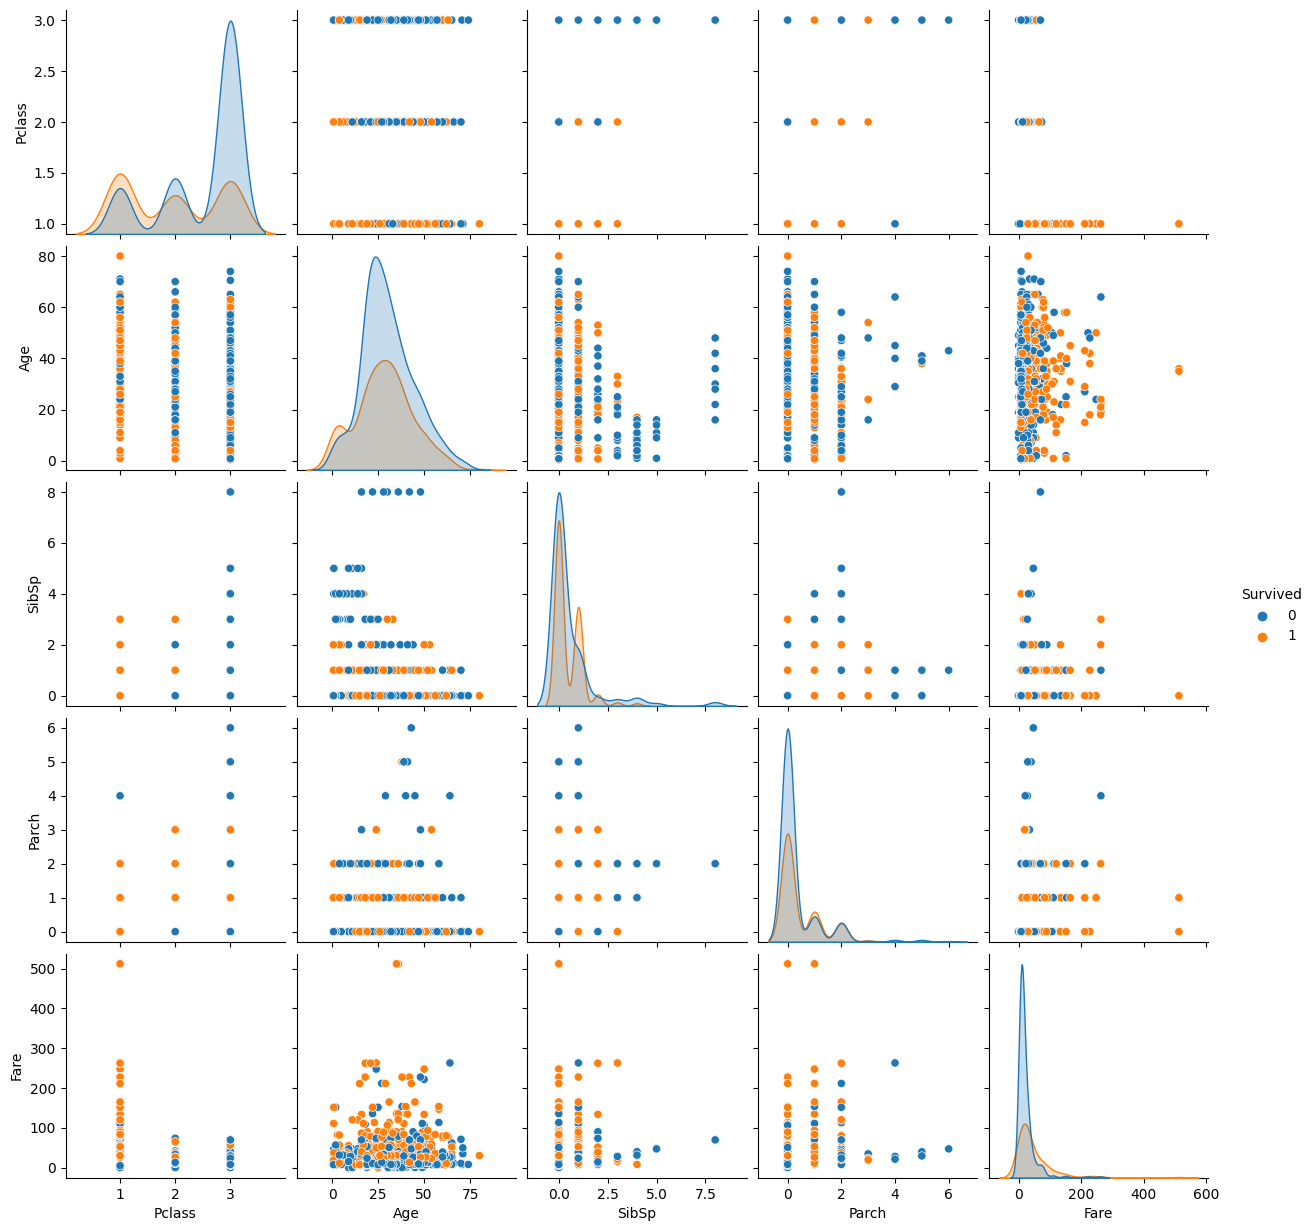

In [27]:
bar = sns.pairplot(titanik_ds_filled,hue='Survived')

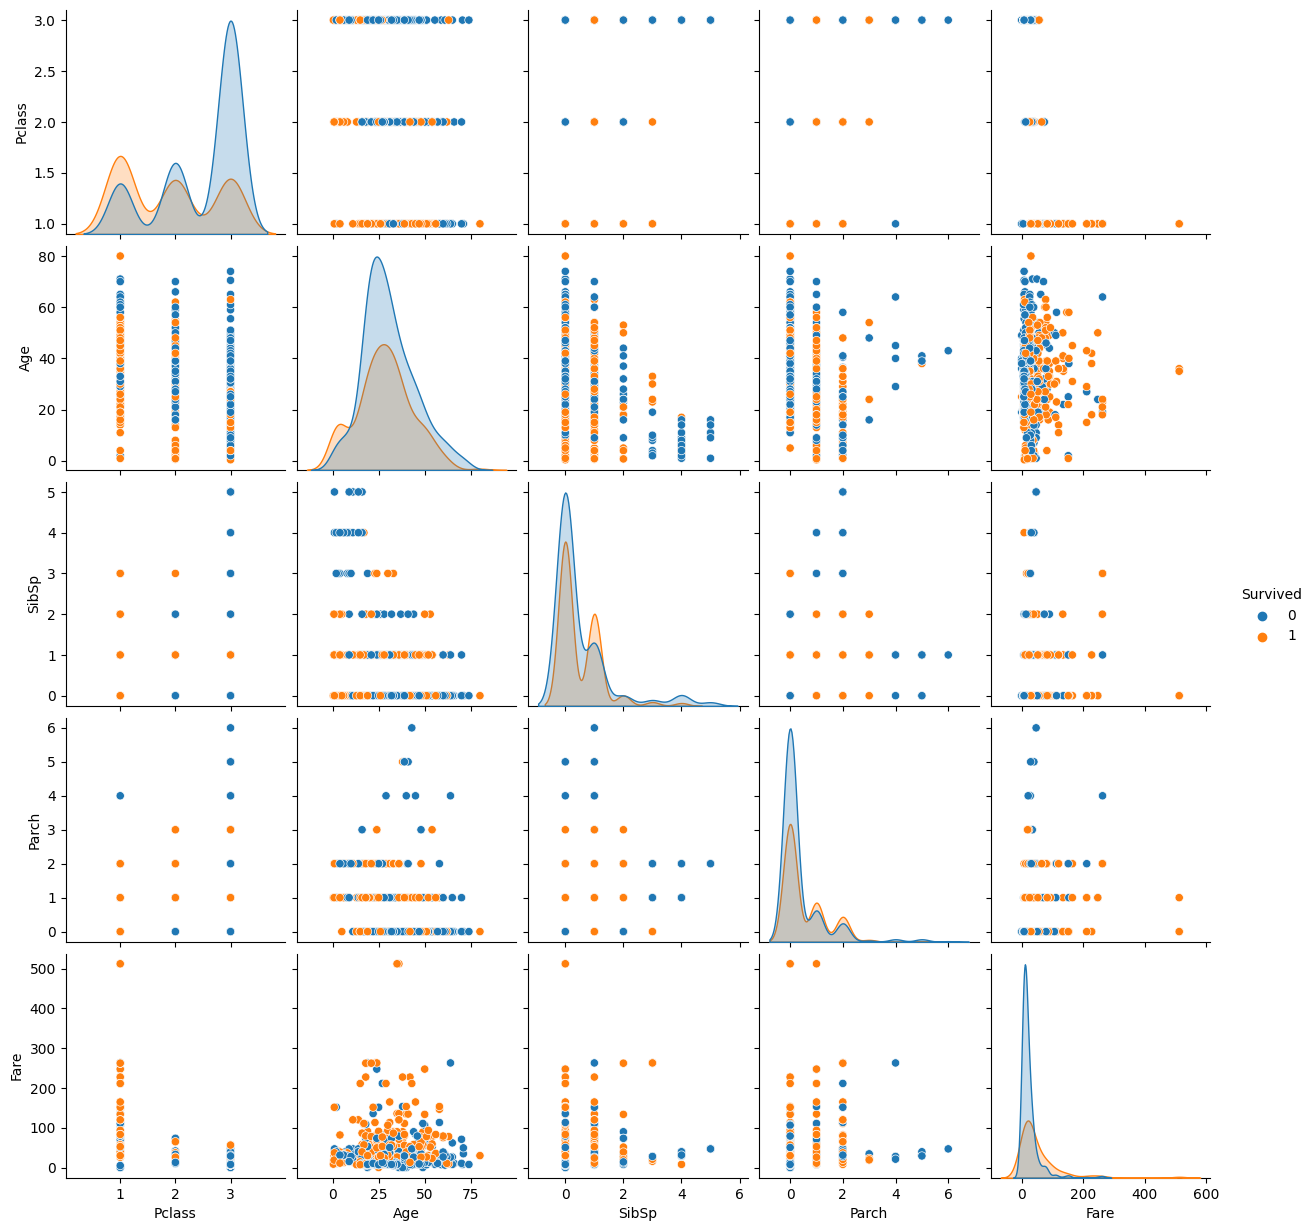

In [28]:
bar = sns.pairplot(titanik_ds_dropped, hue='Survived')

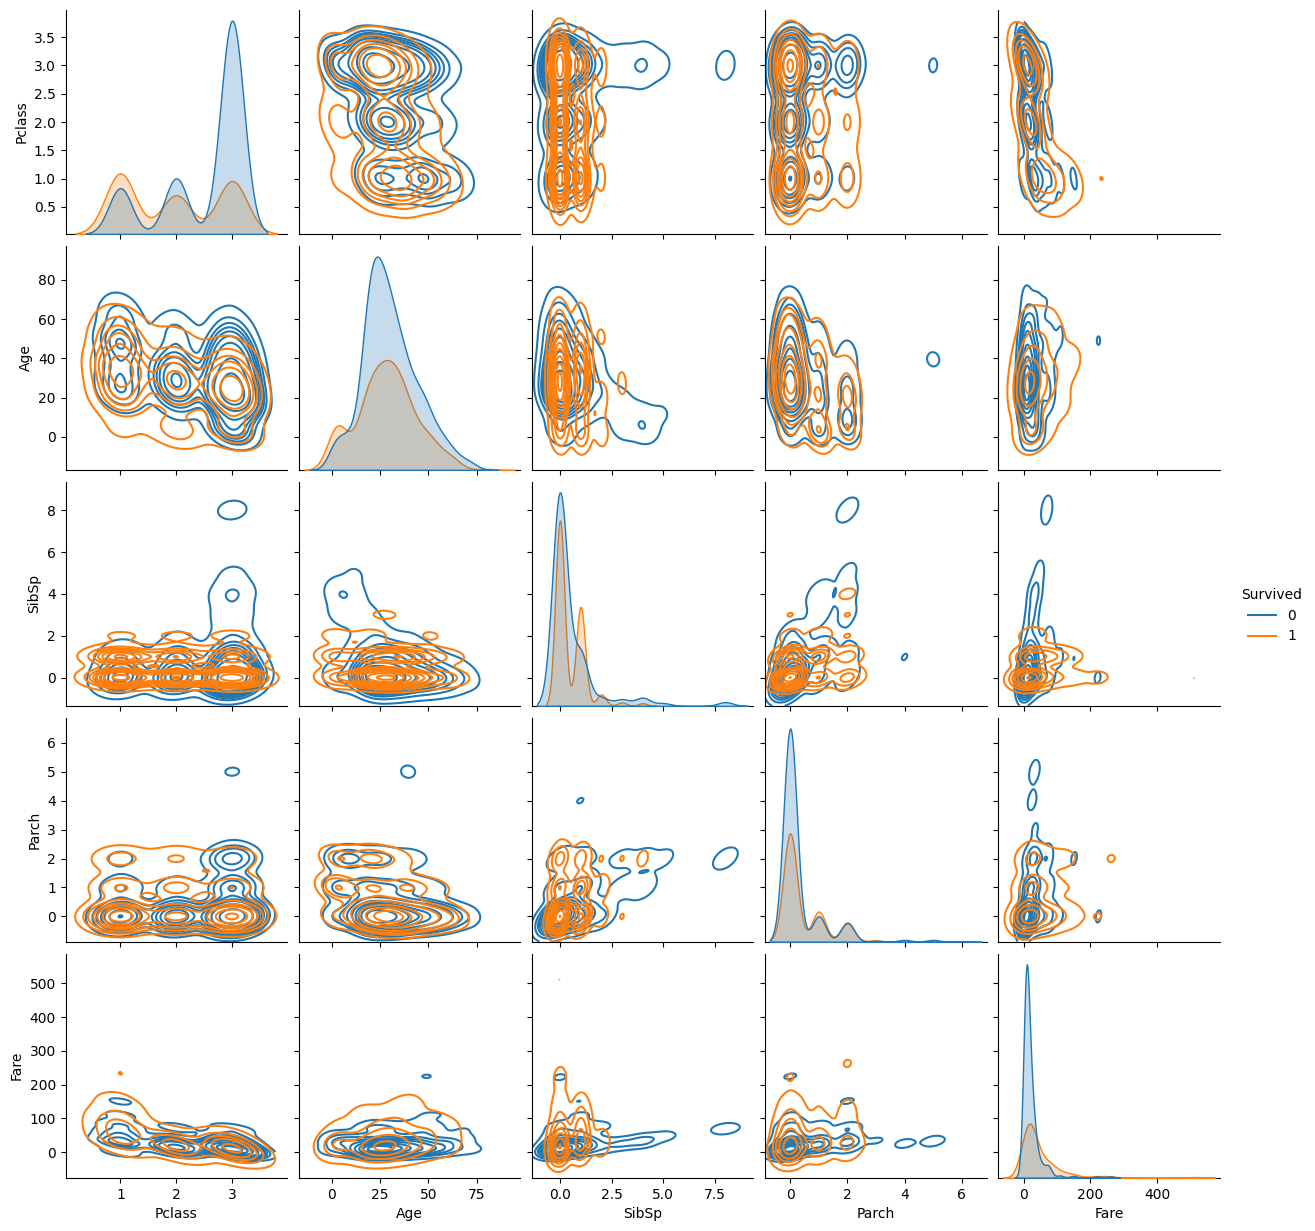

In [29]:
sns.pairplot(titanik_ds_filled, hue='Survived', kind='kde')

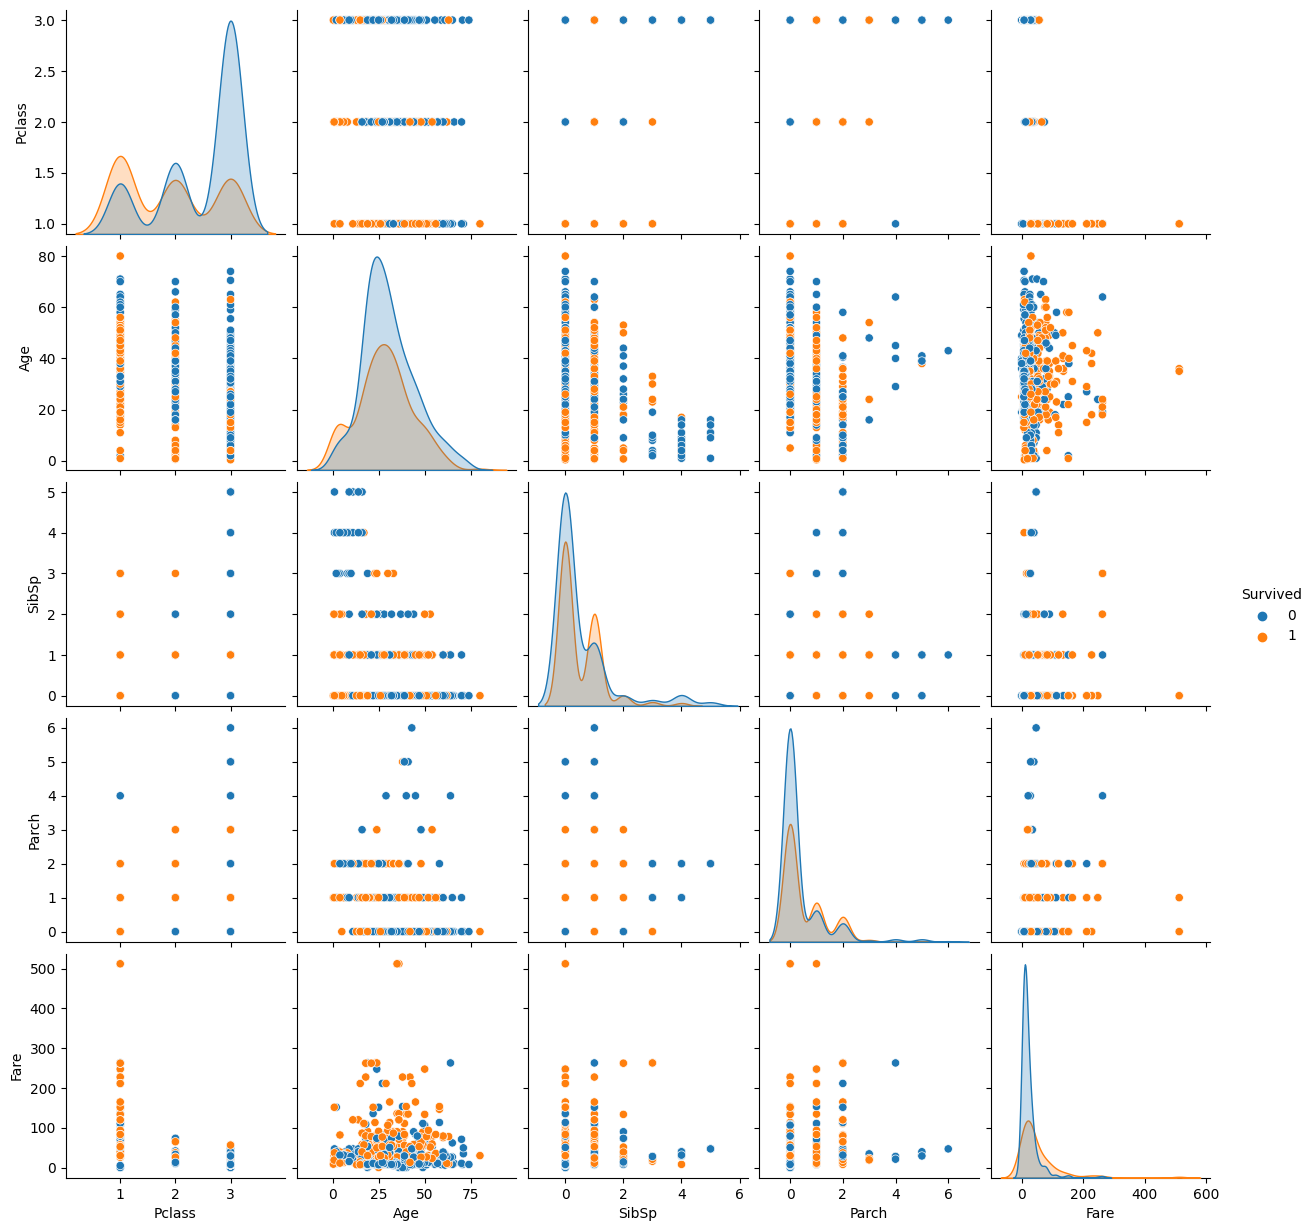

In [30]:
sns.pairplot(titanik_ds_dropped,hue='Survived', kind='scatter')

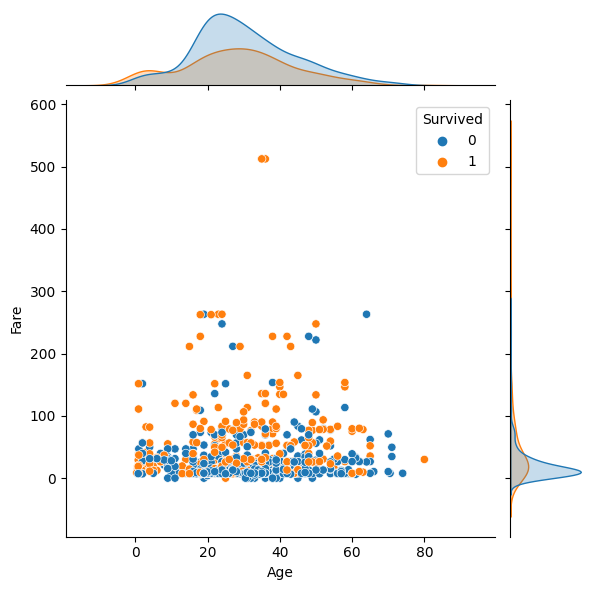

In [37]:
sns.jointplot(data=titanik_ds_filled, x='Age', y='Fare',hue='Survived', kind="scatter")

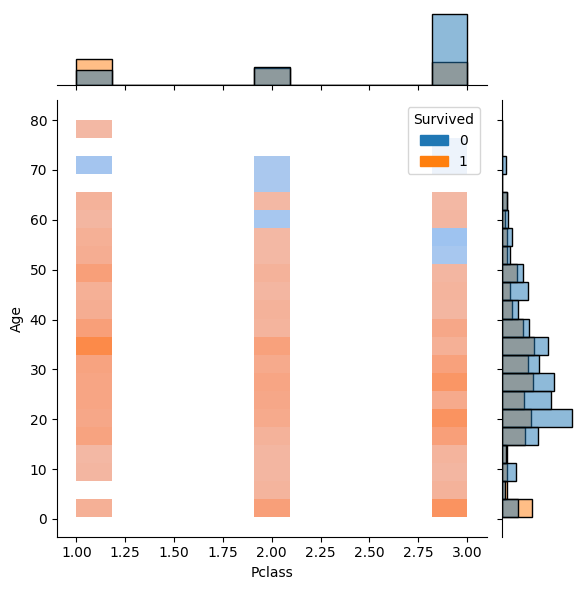

In [39]:
sns.jointplot(data=titanik_ds_filled, x='Pclass', y='Age',hue='Survived',kind='hist')

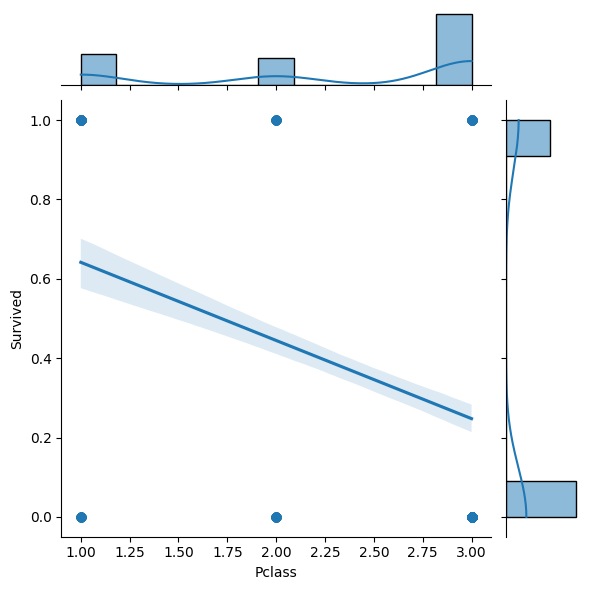

In [23]:
sns.jointplot(data=titanik_ds_filled, x='Pclass', y='Survived', kind="reg")

<Axes: xlabel='Age', ylabel='Count'>

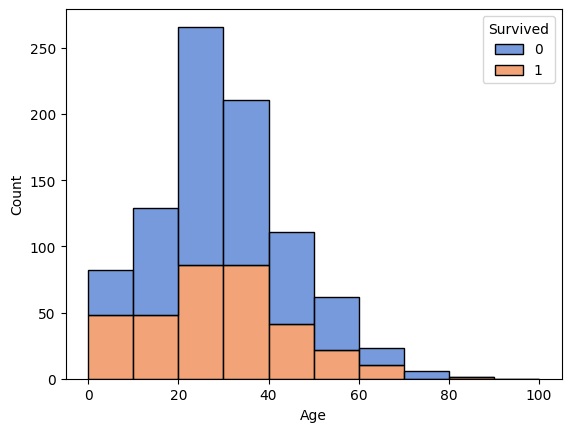

In [24]:
sns.histplot(data=titanik_ds_filled, x='Age', hue='Survived', bins=range(0, 101, 10),multiple='stack', palette='muted')

<Axes: xlabel='возраст_интервал', ylabel='count'>

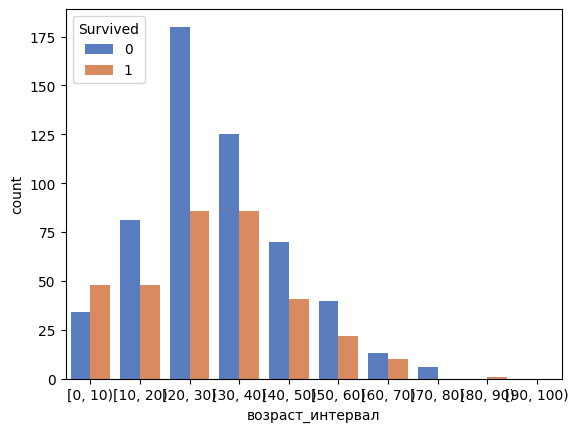

In [40]:
titanik_ds_filled['возраст_интервал'] = pd.cut(titanik_ds_filled['Age'], bins=range(0, 101, 10), right=False)

sns.countplot(data=titanik_ds_filled, x='возраст_интервал', hue='Survived', palette='muted')

<Axes: xlabel='возраст_интервал', ylabel='count'>

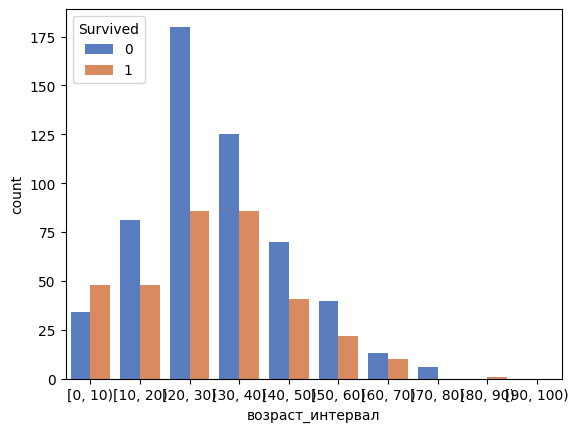

In [42]:
titanik_ds_dropped['возраст_интервал'] = pd.cut(titanik_ds_filled['Age'], bins=range(0, 101, 10), right=False)

sns.countplot(data=titanik_ds_filled, x='возраст_интервал', hue='Survived', palette='muted')